# SSD300 Inference Tutorial

This is a brief tutorial that shows how to use a trained SSD300 for inference on the Pascal VOC datasets. If you'd like more detailed explanations, please refer to [`ssd300_training.ipynb`](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_training.ipynb)

In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast


from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set the image size.

img_height = 300
img_width = 300

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [3]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=20,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'VGG_VOC0712Plus_SSD_300x300_ft_iter_160000.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


Or

### 1.2. Load a trained model

In [72]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'VGG_VOC0712Plus_SSD_300x300_ft_iter_160000.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})

ValueError: Cannot create group in read only mode.

## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [4]:
import glob
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.
frames=glob.glob('../frames/frames_80_90/ff/*.jpg')
i =1
for img_path in frames:
    
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    img = image.img_to_array(img)
    input_images.append(img)
    orig_images.append(imread(img_path))
    
input_images = np.array(input_images)
# We'll only load one image in this example.
print(input_images.shape)

(0,)


In [4]:
img_path = '../graal_2/00597.jpg'
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img)

input_images.append(img)
input_images = np.array(input_images)
orig_images.append(imread(img_path))
print(input_images.shape)

(1, 300, 300, 3)


## 3. Make predictions

In [5]:
y_pred = model.predict(input_images)

In [6]:
print(y_pred.shape)

(1, 200, 6)


`y_pred` contains a fixed number of predictions per batch item (200 if you use the original model configuration), many of which are low-confidence predictions or dummy entries. We therefore need to apply a confidence threshold to filter out the bad predictions. Set this confidence threshold value how you see fit.

In [7]:
confidence_threshold = 0.1

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]
print(len(y_pred_thresh))
np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh)

1
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[array([[  4.  ,   0.79, 180.62, 149.54, 304.3 , 184.81],
       [  4.  ,   0.72, -14.58, 113.88,  95.52, 167.2 ],
       [  4.  ,   0.65, 187.61,  84.15, 301.77, 186.07],
       [  4.  ,   0.53,  94.61, 225.13, 196.45, 307.64]], dtype=float32)]


## 4. Visualize the predictions

We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

621.3158288574218 387.81987030029296 1046.7982568359375 479.26292622884114
-50.14940612792969 295.3229165649414 328.5839593505859 433.6045735677083
645.37205078125 218.2381844584147 1038.0774243164062 482.53205525716146
325.4720758056641 583.826184794108 675.79203125 797.8187237548829


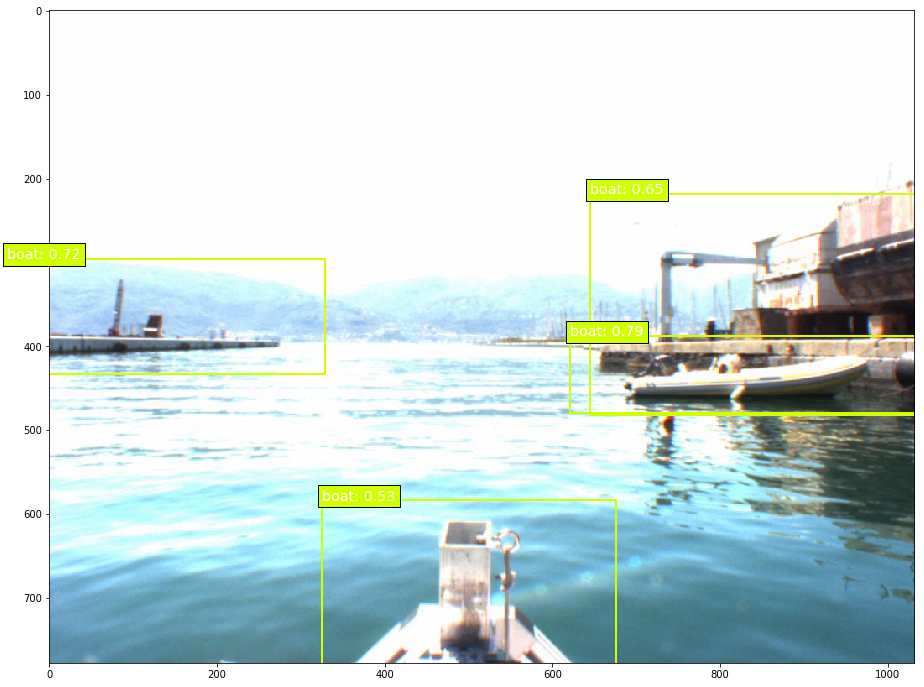

In [8]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']
for i in range(input_images.shape[0]):
    plt.figure(figsize=(20,12))

    plt.imshow(orig_images[i])

    current_axis = plt.gca()

    for box in y_pred_thresh[i]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
        xmin = box[2] * orig_images[i].shape[1] / img_width
        ymin = box[3] * orig_images[i].shape[0] / img_height
        xmax = box[4] * orig_images[i].shape[1] / img_width
        ymax = box[5] * orig_images[i].shape[0] / img_height
        print(xmin,ymin,xmax,ymax)
        color = colors[int(box[0])]
        label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
        current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
        plt.savefig("outputs/ff/output%s.jpg"%(i+275))
        

In [43]:
import cv2 as cv
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(20,12))

img_orig = cv.imread(img_path)
print(img_orig.shape)
current_axis = plt.gca()

for box in y_pred_thresh[0]:
    # Transform the predicted bounding boxes for the 512x512 image to the original image dimensions.
    
    xmin = int(box[-4] * orig_images[0].shape[1] / img_width)
    ymin = int(box[-3] * orig_images[0].shape[0] / img_height)
    xmax =int(box[-2] * orig_images[0].shape[1] / img_width)
    ymax =int(box[-1] * orig_images[0].shape[0] / img_height)
    print(xmin,ymin,xmax,ymax)
    cv.rectangle(img_orig, (int(xmin), int(ymin)), (int(xmax),int(ymax)), (0, 255, 0), 2)
    cv.putText(img_orig,'{}: {:.2f}'.format(classes[int(box[0])], box[1]), (xmin, ymin -10),cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
cv.imwrite("comp_output/1_ssd300.jpg",img_orig)

(480, 640, 3)
206 66 307 231
196 158 305 228


True

ValueError: Image size of 230006x103108 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1440x864 with 1 Axes>

## 5. Make predictions on Pascal VOC 2007 Test

Let's use a `DataGenerator` to make predictions on the Pascal VOC 2007 test dataset and visualize the predicted boxes alongside the ground truth boxes for comparison. Everything here is preset already, but if you'd like to learn more about the data generator and its capabilities, take a look at the detailed tutorial in [this](https://github.com/pierluigiferrari/data_generator_object_detection_2d) repository.

In [10]:
# Create a `BatchGenerator` instance and parse the Pascal VOC labels.

dataset = DataGenerator()

# TODO: Set the paths to the datasets here.

VOC_2007_images_dir         = '../../datasets/VOCdevkit/VOC2007/JPEGImages/'
VOC_2007_annotations_dir    = '../../datasets/VOCdevkit/VOC2007/Annotations/'
VOC_2007_test_image_set_filename = '../../datasets/VOCdevkit/VOC2007/ImageSets/Main/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                  image_set_filenames=[VOC_2007_test_image_set_filename],
                  annotations_dirs=[VOC_2007_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=True,
                  ret=False)

convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

generator = dataset.generate(batch_size=1,
                             shuffle=True,
                             transformations=[convert_to_3_channels,
                                              resize],
                             returns={'processed_images',
                                      'filenames',
                                      'inverse_transform',
                                      'original_images',
                                      'original_labels'},
                             keep_images_without_gt=False)

test.txt: 100%|██████████| 4952/4952 [00:14<00:00, 333.96it/s]


In [13]:
# Generate a batch and make predictions.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Image: ../../datasets/VOCdevkit/VOC2007/JPEGImages/004927.jpg

Ground truth boxes:

[[  7  58  26 433 303]
 [ 15 409  52 439 149]
 [ 15 369  60 394 114]
 [ 15  31  65  45 111]
 [ 15  48  67  65 110]
 [ 15  67  65  81 107]]


In [14]:
# Predict.

y_pred = model.predict(batch_images)

In [16]:
confidence_threshold = 0.5

# Perform confidence thresholding.
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

# Convert the predictions for the original image.
y_pred_thresh_inv = apply_inverse_transforms(y_pred_thresh, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  7.     1.    59.19  20.12 429.33 307.77]
 [ 15.     0.89 361.66  55.22 394.27 122.28]
 [ 15.     0.7   89.83  65.21 108.34 116.95]
 [ 15.     0.57 345.61  57.24 368.72 108.1 ]
 [ 15.     0.55 430.29  61.72 462.75 140.24]
 [ 15.     0.53 406.14  56.13 436.42 145.34]
 [ 15.     0.52  40.03  67.8   55.35 109.8 ]]


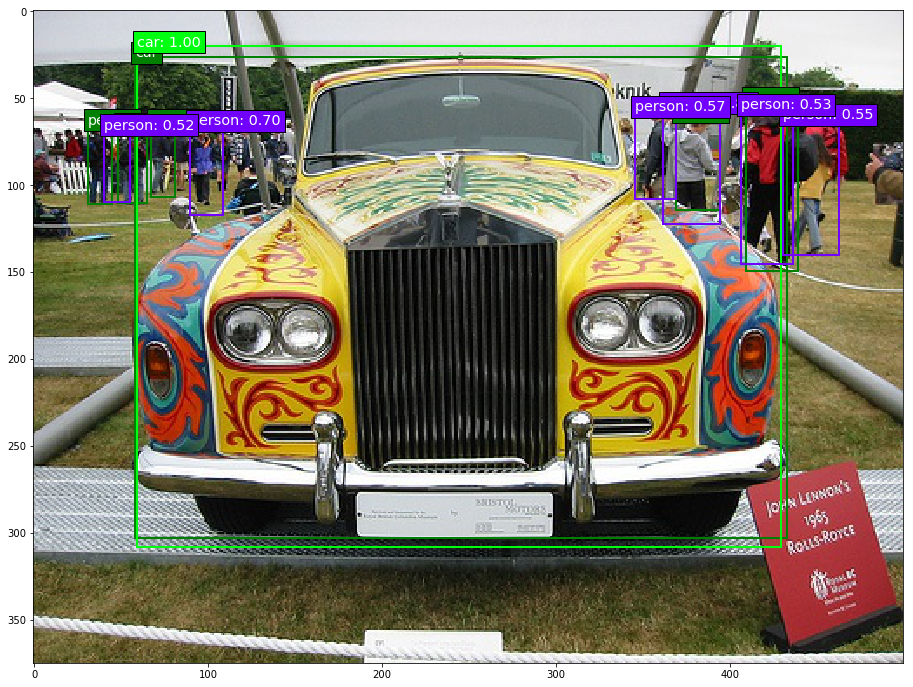

In [18]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_thresh_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [ ]:
# import the necessary packages
from imutils.video import VideoStream
import argparse
import datetime
import imutils
import time
import cv2
import time


# construct the argument parser and parse the arguments

 
# if the video argument is None, then we are reading from webcam

 
# otherwise, we are reading from a video file

vs = cv2.VideoCapture('day2_2.avi')

# initialize the first frame in the video stream
firstFrame = None
frameCount =0
inferencesCount=0
inferencesCountFinal=0
framesCountFinal=0
frame_width = int(vs.get(3))
frame_height = int(vs.get(4))
print(frame_width)
print(frame_height)
out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 30, (300,300))
while True:
    # grab the current frame and initialize the occupied/unoccupied
    # text
    frame = vs.read()[1]
    text = "Changed"
 
    # if the frame could not be grabbed, then we have reached the end
    # of the video
    if frame is None:
        break
    frameCount+=1
    
    # resize the frame, convert it to grayscale, and blur it
    frame = imutils.resize(frame, width=500)
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (21, 21), 0)
 
    # if the first frame is None, initialize it
    if firstFrame is None:
        
        start = time.time()
        
        firstFrame = gray
        continue
    frameDelta = cv2.absdiff(firstFrame, gray)
    thresh = cv2.threshold(frameDelta, 30, 255, cv2.THRESH_BINARY)[1]
 
    # dilate the thresholded image to fill in holes, then find contours
    # on thresholded image
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
 
    # loop over the contours
    important_cnts =0
    for c in cnts:
        # if the contour is too small, ignore it
        if cv2.contourArea(c) < 100:
            continue
        important_cnts +=1
        
        # compute the bounding box for the contour, draw it on the frame,
        # and update the text
        (x, y, w, h) = cv2.boundingRect(c)
       
        if(y+h<200):
            continue
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        text = "Changed"
        cv2.putText(frame, "Frame Status: {}".format(text), (10, 20),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    if(important_cnts>0):
        inferencesCount+=1
    #cv2.putText(frame, datetime.datetime.now().strftime("%A %d %B %Y %I:%M:%S%p"),
    #(10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1)
    end = time.time()
    if(end-start>1):
       
        start =time.time()
        framesCountFinal = frameCount
        frameCount=1
        
        inferencesCountFinal = inferencesCount
        inferencesCount=0
    cv2.putText(frame,"Inferences per second:{}/{} frames".format(inferencesCountFinal,framesCountFinal),(10,40),cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1)
    
 
    # show the frame and record if the user presses a key
    cv2.imshow("Security Feed", frame)
    cv2.imshow("Thresh", thresh)
    cv2.imshow("Frame Delta", frameDelta)
    key = cv2.waitKey(8) & 0xFF
 
    # if the `q` key is pressed, break from the lop
    if key == ord("q"):
        break
    out.write(frame)
# cleanup the camera and close any open windows
    firstFrame = gray
vs.release()
cv2.destroyAllWindows()
out.release()